In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import talib as ta
import tqdm
import random

In [2]:
csv_use_cols = ["Open", "High", "Low", "Close", "Volume"]
shift = 5
csvfilename = "../data/gmo/gmo_data.csv"

In [3]:
def label_func(x):
    if x > 0.00045: return 2
    elif x < -0.00045: return -2
    elif x > 0.000095: return 1
    elif x < -0.000015: return -1
    else: return 0

In [4]:
df = pd.read_csv(csvfilename,usecols=csv_use_cols)

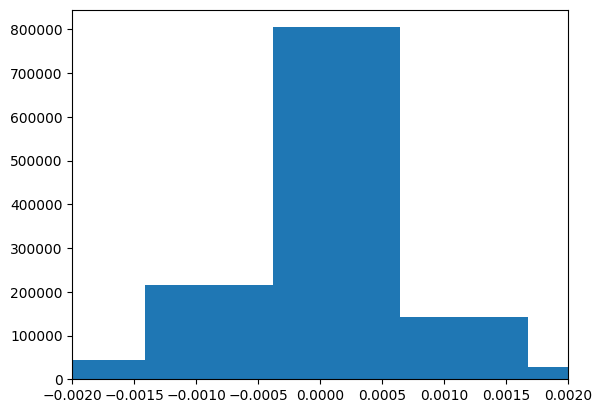

/home/kanai/btcb/.venv/lib/python3.11/site-packages/numpy/lib/function_base.py:2455: RuntimeWarning: invalid value encountered in label_func (vectorized)
  outputs = ufunc(*inputs)


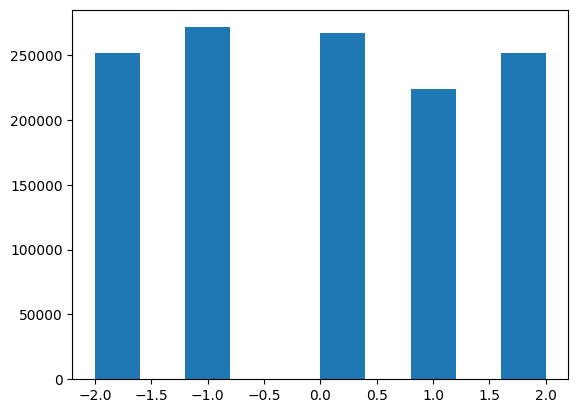

      Open     High      Low    Close  Volume  log_close  diff_log_close  \
0  6758448  6764919  6758448  6764919  0.2240  15.727261             NaN   
1  6764919  6764940  6758680  6764900  0.2674  15.727258       -0.000003   
2  6764940  6764940  6764940  6764940  0.0002  15.727264        0.000006   
3  6764920  6764920  6764920  6764920  0.0400  15.727261       -0.000003   
4  6764920  6764920  6764920  6764920  0.0020  15.727261        0.000000   
5  6764920  6769879  6764920  6769879  0.1200  15.727994        0.000733   
6  6760961  6777656  6760961  6777656  1.3420  15.729142        0.001148   
7  6761441  6772754  6761441  6772299  0.0626  15.728351       -0.000791   
8  6772257  6772258  6772257  6772258  0.0080  15.728345       -0.000006   
9  6765244  6765244  6765244  6765244  0.0180  15.727309       -0.001036   

   target  
0     0.0  
1     0.0  
2     0.0  
3     0.0  
4     2.0  
5     2.0  
6    -2.0  
7     0.0  
8    -2.0  
9     0.0  


In [5]:
df["log_close"] = np.log(df["Close"])
df["diff_log_close"] = df["log_close"].diff()
plt.hist(df["diff_log_close"].dropna(), bins=100)
plt.xlim(-0.002,0.002)
plt.show()
df["target"] = np.vectorize(label_func)(df["diff_log_close"])
plt.hist(df["target"])
plt.show()
df["target"] = df["target"].shift(-1)
print(df.head(10))

In [6]:
df["EMA5"] = ta.EMA(df["Close"], timeperiod=5)
df["EMA50"] = ta.EMA(df["Close"], timeperiod=50)
df["EMA20000"] = ta.EMA(df["Close"], timeperiod=20000)
df["diff_EMA20000"] = df["EMA20000"].diff()
df["RSI"] = ta.RSI(df["Close"], timeperiod=14)
df["MFI"] = ta.MFI(df["High"], df["Low"], df["Close"], df["Volume"], timeperiod=1400)
df = df.dropna()

fig = plt.figure(figsize=(30, 15))
ax1 = fig.add_subplot(111)

ax1.plot(df["EMA5"], label="EMA5")

ax2 = ax1.twinx()
ax2.plot(df["MFI"], label="MFI", color="green")

plt.show()

In [7]:
class buy_sell_bot:
    def __init__(self, jpy:float, btc:float)->None:
        self.vol_btc = btc
        self.vol_jpy = jpy

    def buy(self, price: float, vol: float)->None:
        if self.vol_jpy < price * vol:
            return
        self.vol_btc += vol
        self.vol_jpy -= price * vol
        return

    def sell(self, price: float, vol: float)->None:
        if self.vol_btc < vol:
            return
        self.vol_btc -= vol
        self.vol_jpy += price * vol
        return
    
    def get_jpy(self)->float:
        return self.vol_jpy
    
    def get_btc(self)->float:
        return self.vol_btc

## ランダム売買シミュレーション

In [8]:
random.seed(0)
Bot = buy_sell_bot(jpy=100000, btc=0)
probdict = {'sell':0.333333, 'buy':0.333333, 'hold':0.333333}
myassetlist = []
for index, data in df.iterrows():
    myassetlist.append(Bot.get_jpy()+Bot.get_btc()*data["Open"])
    if random.random() > (1-probdict['buy']):
        Bot.buy(data["Close"], 0.005)
    elif random.random() > (1-probdict['buy']-probdict['sell']):
        Bot.sell(data["Close"], 0.005)
    else:
        continue

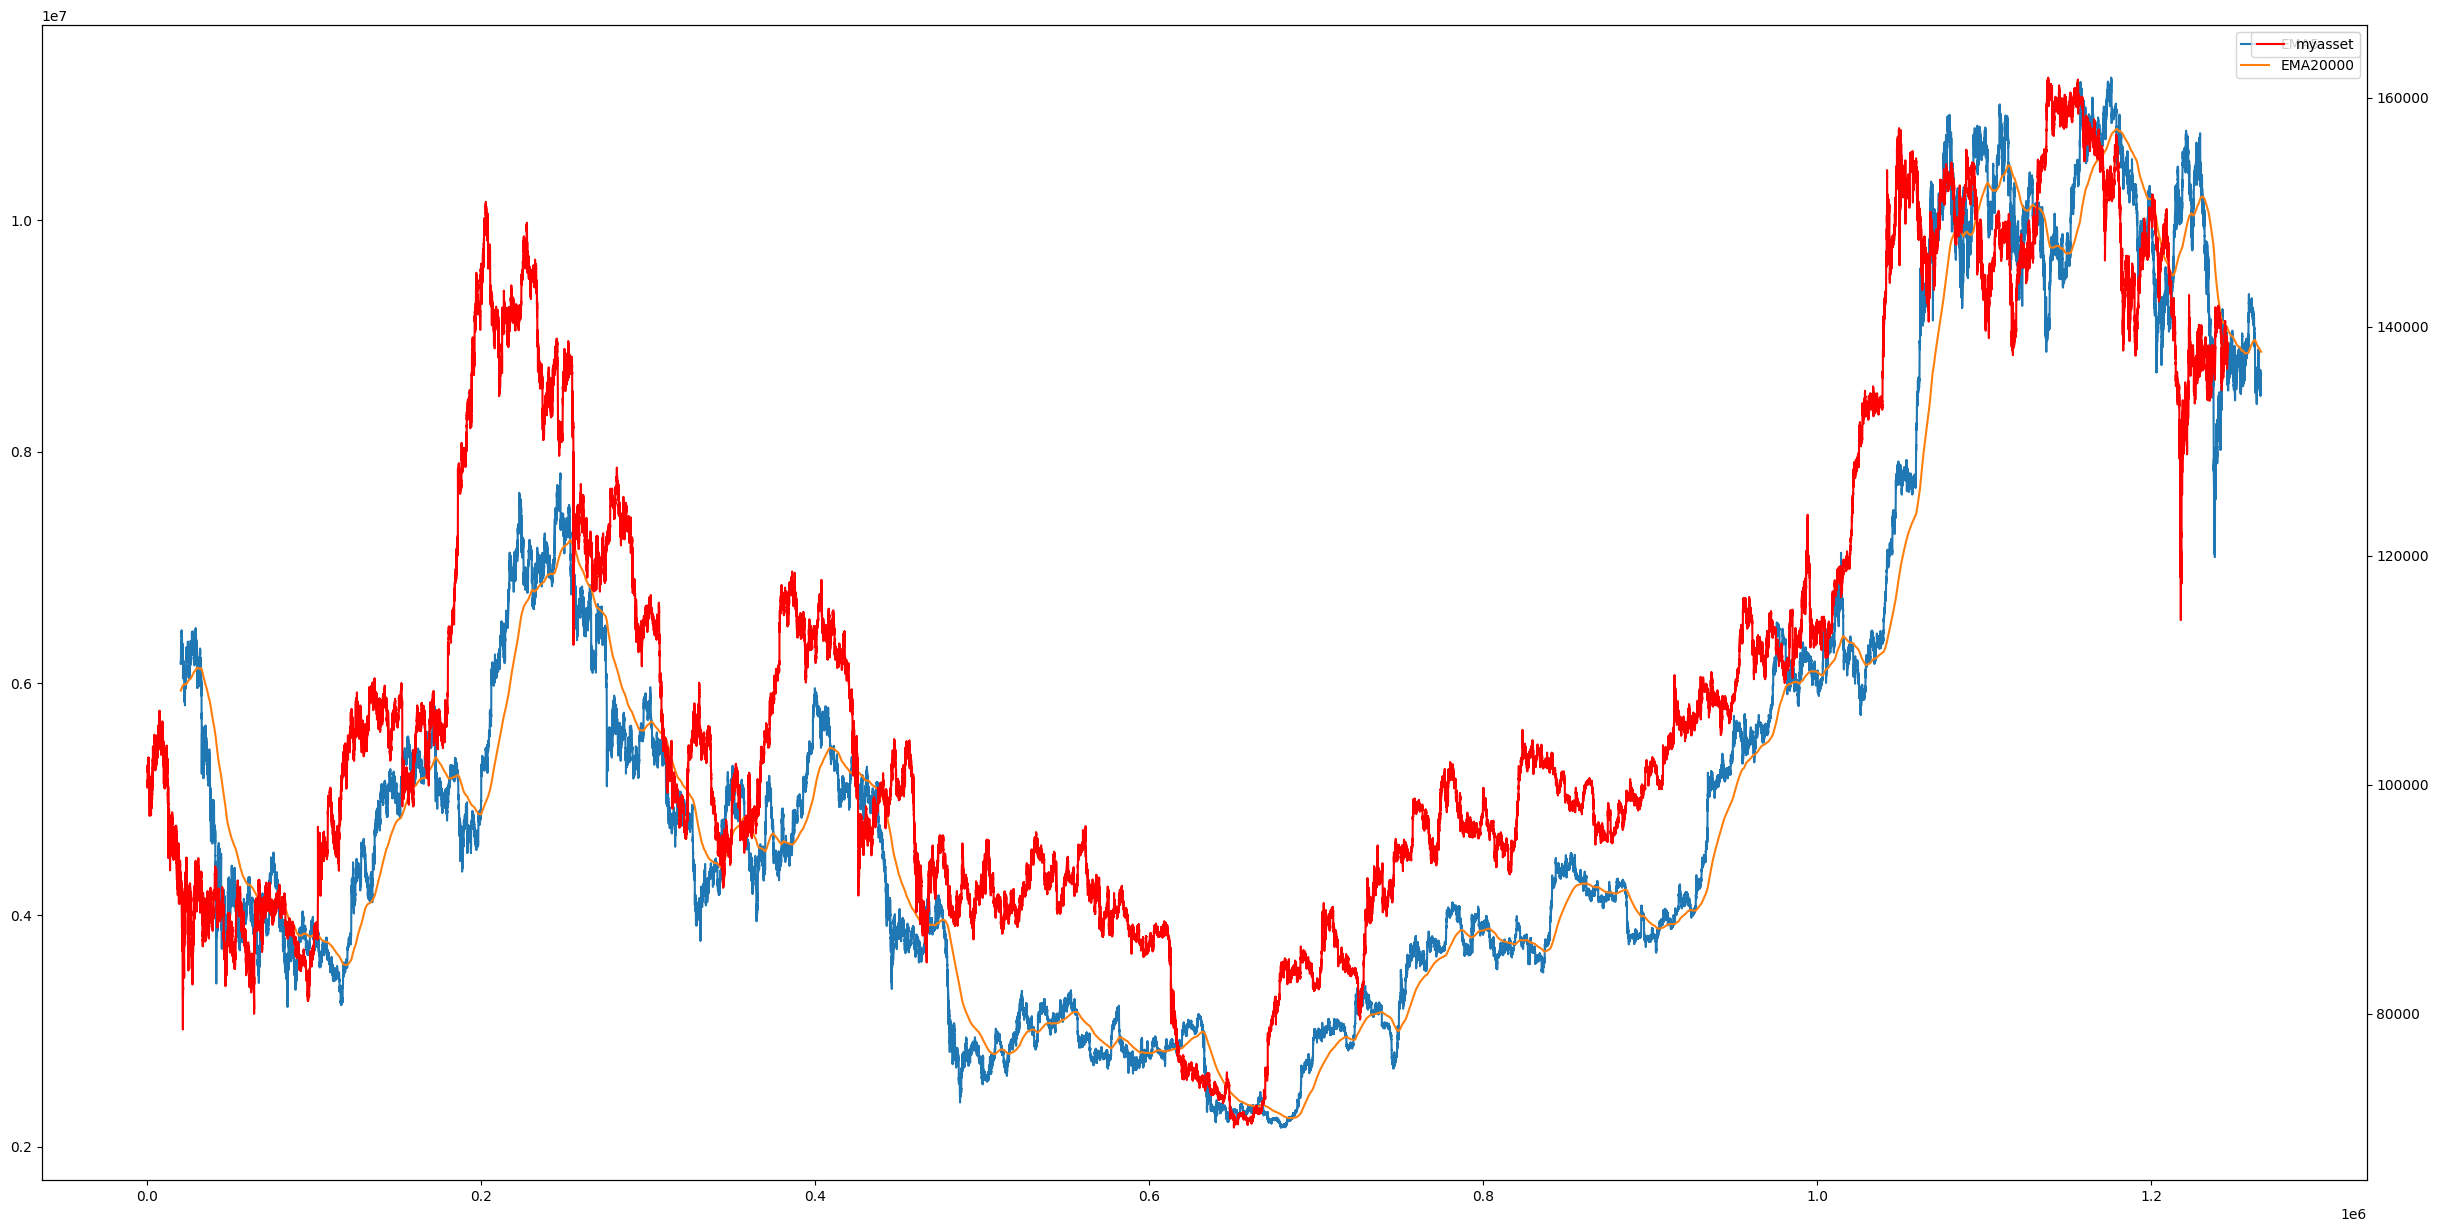

In [9]:
fig = plt.figure(figsize=(30, 15))
ax1 = fig.add_subplot(111)

ax1.plot(df["EMA5"], label="EMA5")
ax1.plot(df["EMA20000"], label="EMA20000")
ax1.legend()

ax2 = ax1.twinx()
ax2.plot(myassetlist, label="myasset", color="red")
ax2.legend()

plt.show()

# 順張り売買シミュレーション

In [10]:
random.seed(0)
Bot = buy_sell_bot(jpy=100000, btc=0)
probdict = {'sell':0.333333, 'buy':0.333333, 'hold':0.333333}
myassetlist = []
for index, data in df.iterrows():
    if data["diff_EMA20000"] > 0:
        probdict['buy'] = 0.9
        probdict['sell'] = 0
        probdict['hold'] = 0.1
    else:
        probdict['buy'] = 0.05
        probdict['sell'] = 0.3
        probdict['hold'] = 0.6
    myassetlist.append(Bot.get_jpy()+Bot.get_btc()*data["Open"])
    if random.random() > (1-probdict['buy']):
        Bot.buy(data["Close"], 0.005)
    elif random.random() > (1-probdict['buy']-probdict['sell']):
        Bot.sell(data["Close"], 0.005)
    else:
        continue

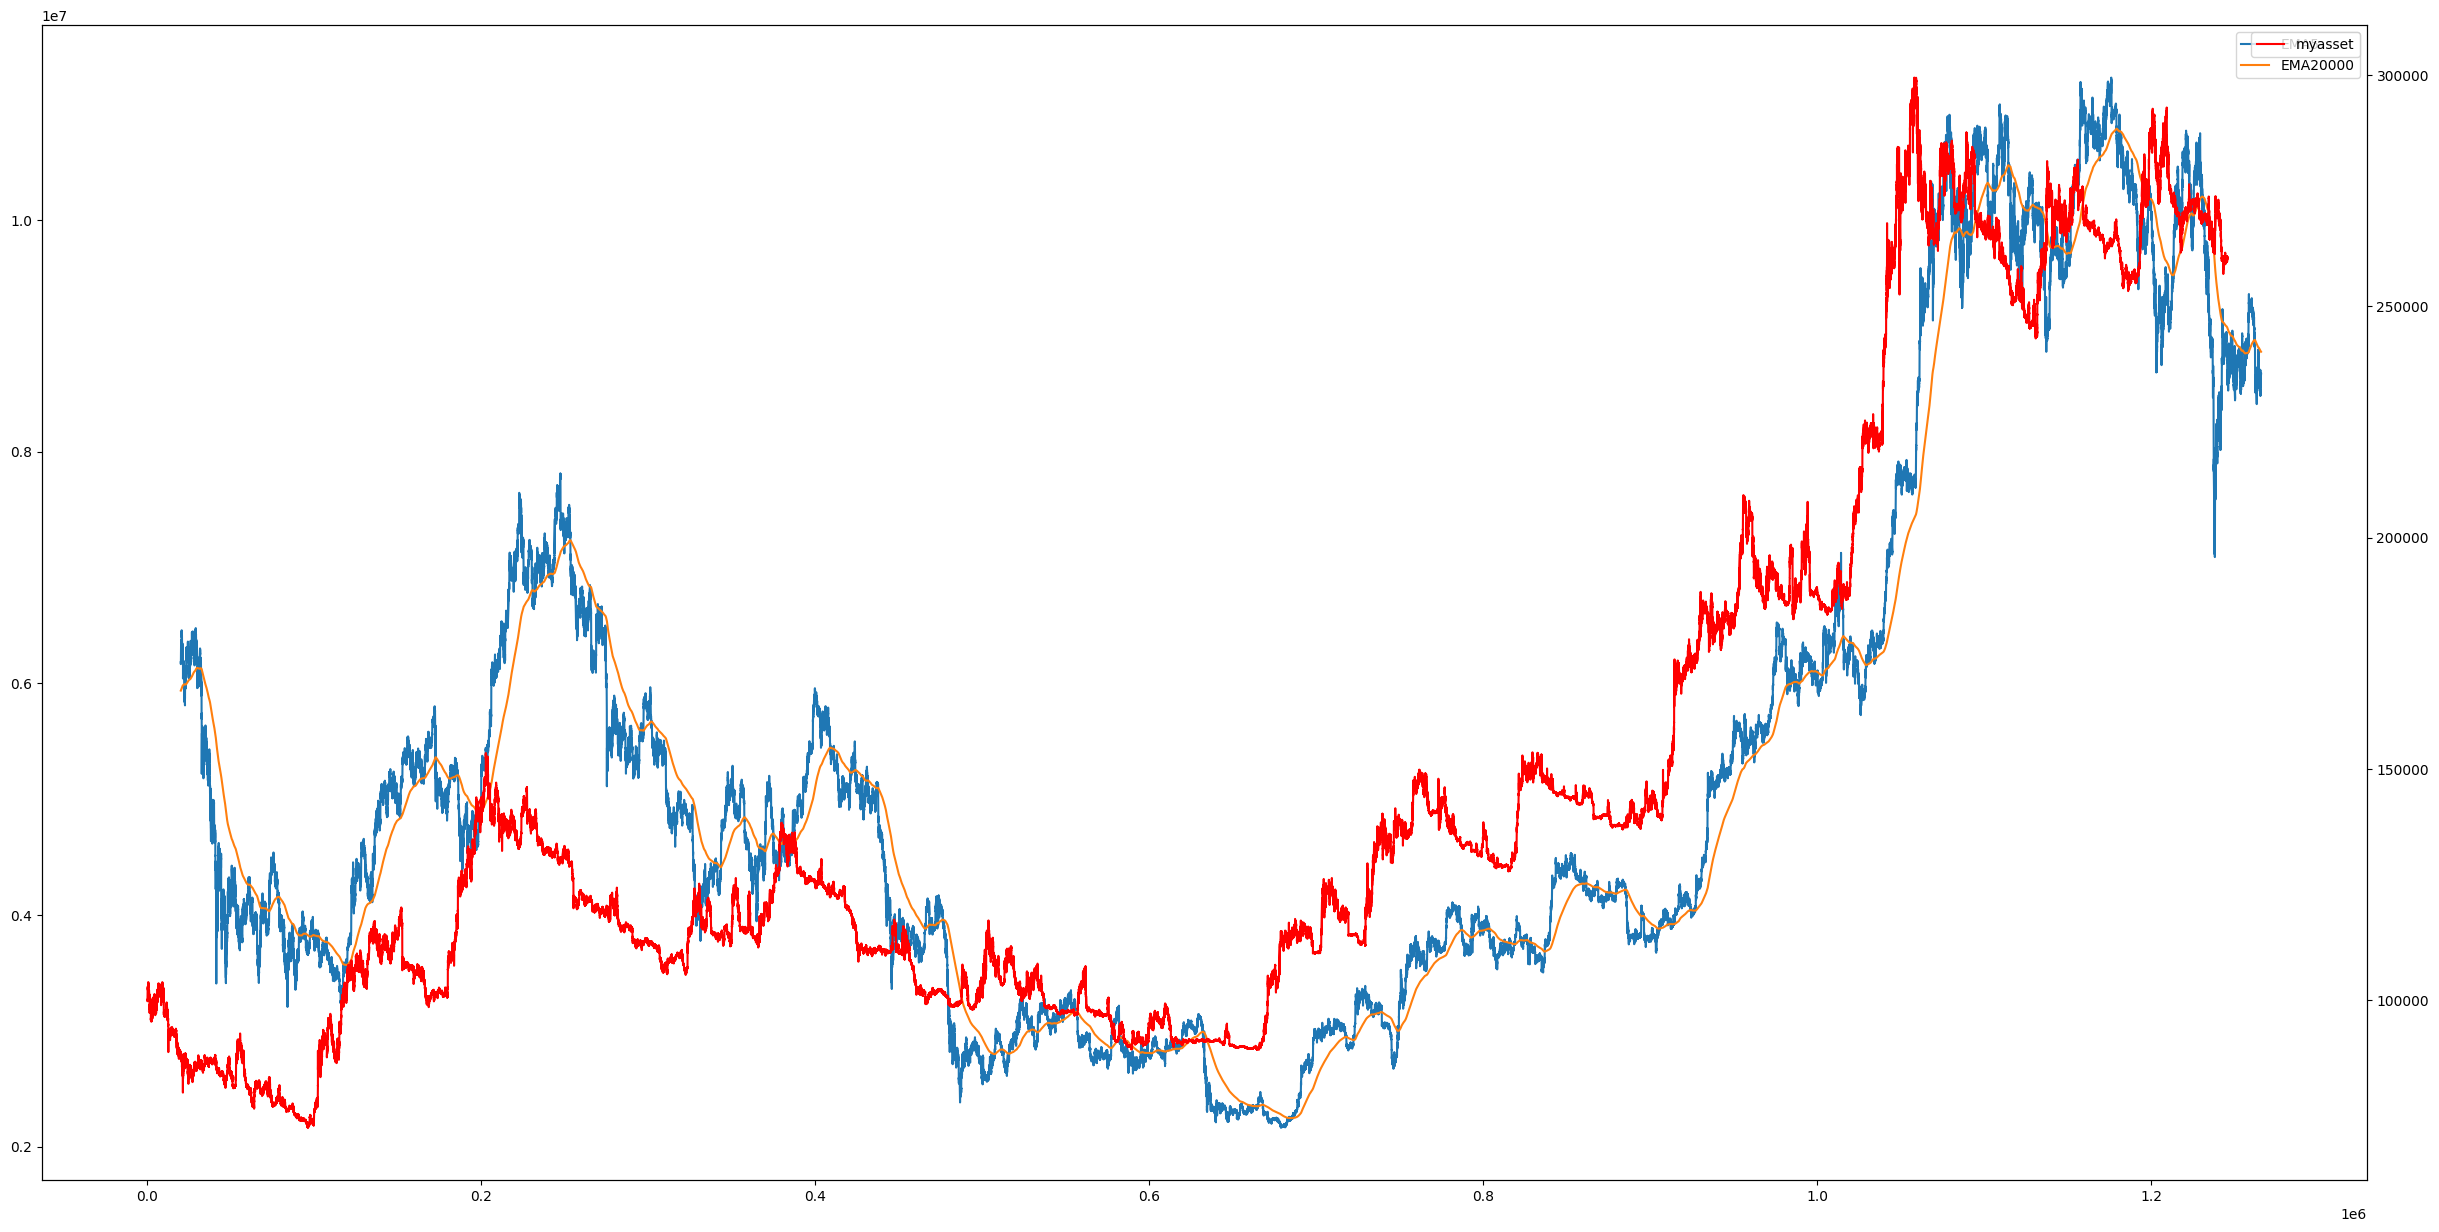

In [11]:
fig = plt.figure(figsize=(30, 15))
ax1 = fig.add_subplot(111)

ax1.plot(df["EMA5"], label="EMA5")
ax1.plot(df["EMA20000"], label="EMA20000")
ax1.legend()

ax2 = ax1.twinx()
ax2.plot(myassetlist, label="myasset", color="red")
#ax2.plot(df["MFI"], label="MFI")
ax2.legend()

plt.show()